#Setup

In [2]:
#Importations for datasets
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import PIL
from PIL import Image
from glob import glob

In [3]:
#GET Data
from google.colab import files
files.upload() #Upload kaggle.json here.

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
#Unzip 
!mkdir aisegment-split-1
%cd aisegment-split-1
!kaggle datasets download -d vincenttu/aisegment-split-1
!unzip -q aisegment-split-1.zip
!rm aisegment-split-1.zip
%cd 

/content/aisegment-split-1
100% 3.56G/3.56G [00:29<00:00, 105MB/s]
100% 3.56G/3.56G [00:29<00:00, 129MB/s]
/root


#Preprocessing

In [5]:
filepaths = list(glob('/content/aisegment-split-1/*'))

In [6]:
labels_paths=[]
img_paths=[]
for filepath in filepaths:
  if 'label' in filepath:
    labels_paths.append(filepath)
  else:
    img_paths.append(filepath)

In [7]:
for label_path in labels_paths:
  if '/content/aisegment-split-1/label_._1803241125-00000005.jpg' in label_path:
    labels_paths.remove(label_path)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:133: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


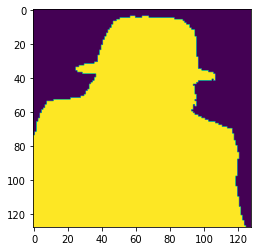

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, labels_paths, img_paths):
        super().__init__()
        self.labels_paths = sorted(labels_paths)
        self.img_paths = sorted(img_paths)
        self.tfm_both = T.Compose([
          T.ToTensor(),
          T.Resize((128, 128))
        ])


        self.tfm_train = T.Compose([
          T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        self.tfm_label = T.Compose([
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels_paths[idx]
        image = self.img_paths[idx]

        label = np.asarray(Image.open(label))
        image = np.asarray(Image.open(image))

        label = label[:, :, 3]
        label = np.expand_dims(label, axis=2)

        label = self.tfm_both(label) 
        image = self.tfm_both(image)

        label = self.tfm_label(label)
        image = self.tfm_train(image)

        label = (label>0).type(torch.FloatTensor)  # np.float32, float
        
        return label, image

data = CustomImageDataset(labels_paths, img_paths)
x=data[0][0]
plt.imshow(np.squeeze(x))


#Building Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 60, 2, stride=1)
        self.conv2 = nn.Conv2d(60, 120, 2, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(120, 120, 2, stride=1)
        self.conv4 = nn.Conv2d(120, 120, 2, stride=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5, 120*24)
        self.fc2 = nn.Linear(120*24, 84)
        self.fc3 = nn.Linear(84, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        print(x.shape)
        x = F.relu(self.conv1(x))
        print(x.shape)
        x = F.relu(self.conv2(x))
        print(x.shape)

        x = self.pool(x)
        print(x.shape)

        x = F.relu(self.conv3(x))
        print(x.shape)
        x = F.relu(self.conv4(x))
        print(x.shape)

        x = self.pool2(x)
        print(x.shape)

        x = F.relu(self.fc1(x))
        print(x.shape)

        x = F.relu(self.fc2(x))
        print(x.shape)

        x = self.fc3(x)
        print(x.shape)

        x = x.view(-1, 64)
        print(x.shape)

        output = self.out(x)
        print(x.shape)
        output=F.relu(x)
        print(x.shape)
        output = output.view(64, 600)
        print(x.shape)

        return output


model = GarmentClassifier()
model.eval()

x = torch.rand(20, 1, 512, 512)
with torch.no_grad():
  z = model(x)

print(z)
#model.forward(training_data)

torch.Size([20, 1, 512, 512])
torch.Size([20, 60, 511, 511])
torch.Size([20, 120, 510, 510])
torch.Size([20, 120, 255, 255])
torch.Size([20, 120, 254, 254])
torch.Size([20, 120, 253, 253])
torch.Size([20, 120, 126, 126])


RuntimeError: ignored

preprocessing: pytorch, dataloader (a tensor for input, another tensor for labels, dimension n color channels)
remove label path 

normalization 

resize (nxn)

building model: take a look at architecture 
train: input can go in, output: expected shape 
train --> evaluate 
